# About

- In this notebook I will train Yolo v8 model to detect PPE (Personal Protective Equipment), using [this existing dataset](https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow) from [Roboflow](https://universe.roboflow.com/)
- In the [next notebook](https://www.kaggle.com/hinepo/yolov8-inference-for-red-zone-application) I will use this custom model to make inference on videos and post-process the results so they can be used in a Red Zone/Trespassing detection application
- This notebook is a generic training pipeline that you can use to train any Yolo v8 model for object detection task on any dataset (images/number of classes), as long as you provide the dataset in the correct folder structure accepted by Yolo and the annotations/labels in Yolo format
- [Ultralytics - docs](https://docs.ultralytics.com/)
- [Ultralytics - github](https://github.com/ultralytics/ultralytics)

[CSS (Construction Site Safety) Dataset](https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow):

- Labels in this dataset:
    - 0: Hardhat
    - 1: Mask
    - 2: NO-Hardhat
    - 3: NO-Mask
    - 4: NO-Safety Vest
    - 5: Person
    - 6: Safety Cone
    - 7: Safety Vest
    - 8: Machinery
    - 9: Vehicle


- More info:
    - Number of classes: 10
    - Label Annotation: YOLO format (.txt)
      - `[class_id, center_x, center_y, width, height]`

Yolo Dataset folder structure: the paths to these folders will be written to a YAML file that will be used by Yolo.

```
Custom dataset directory (root)
    - train
        - images (folder including all training images)
        - labels (folder including all training labels)
    - validation
        - images (folder including all validation images)
        - labels (folder including all validation labels)
    - test
        - images (folder including all test images)
        - labels (folder including all test labels)

```

In [1]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2283bdf5-efce-5bea-944d-ac48e1cdbc71)
GPU 1: Tesla T4 (UUID: GPU-d2350905-f225-0606-24a2-90763eafc219)


# Installs/Imports

In [2]:
%%time

! pip install --upgrade ultralytics -qq

CPU times: user 216 ms, sys: 30.9 ms, total: 246 ms
Wall time: 16.6 s


In [3]:
import ultralytics
print(ultralytics.__version__)

8.0.173


In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [5]:
! wandb disabled

W&B disabled.


# CFG

- CFG class enables easy and organized experimentation

In [6]:
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88

    # classes
    CLASSES = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask',
               'NO-Safety Vest', 'Person', 'Safety Cone',
               'Safety Vest', 'machinery', 'vehicle']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 100
    BATCH_SIZE = 16
    
    BASE_MODEL = 'yolov8x' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'
    
    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0    

    # paths
    CUSTOM_DATASET_DIR = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/'
    OUTPUT_DIR = './'

# Create YAML file

- Create ```data.yaml``` file properly formatted to be used by Yolo

In [7]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [8]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- machinery
- vehicle
nc: 10
test: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test
train: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train
val: /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid



# Dataset

- Check some images
- Image utils

## Visualize one image

In [9]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



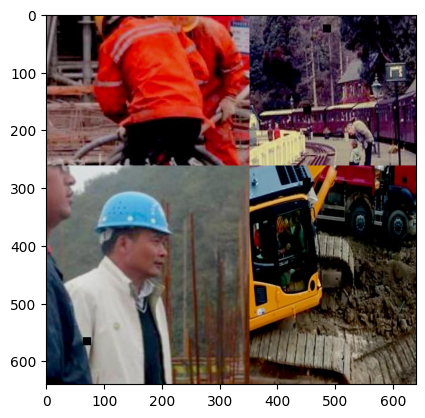

In [10]:
example_image_path = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

## Visualize many images

In [11]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):
    
    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
        
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

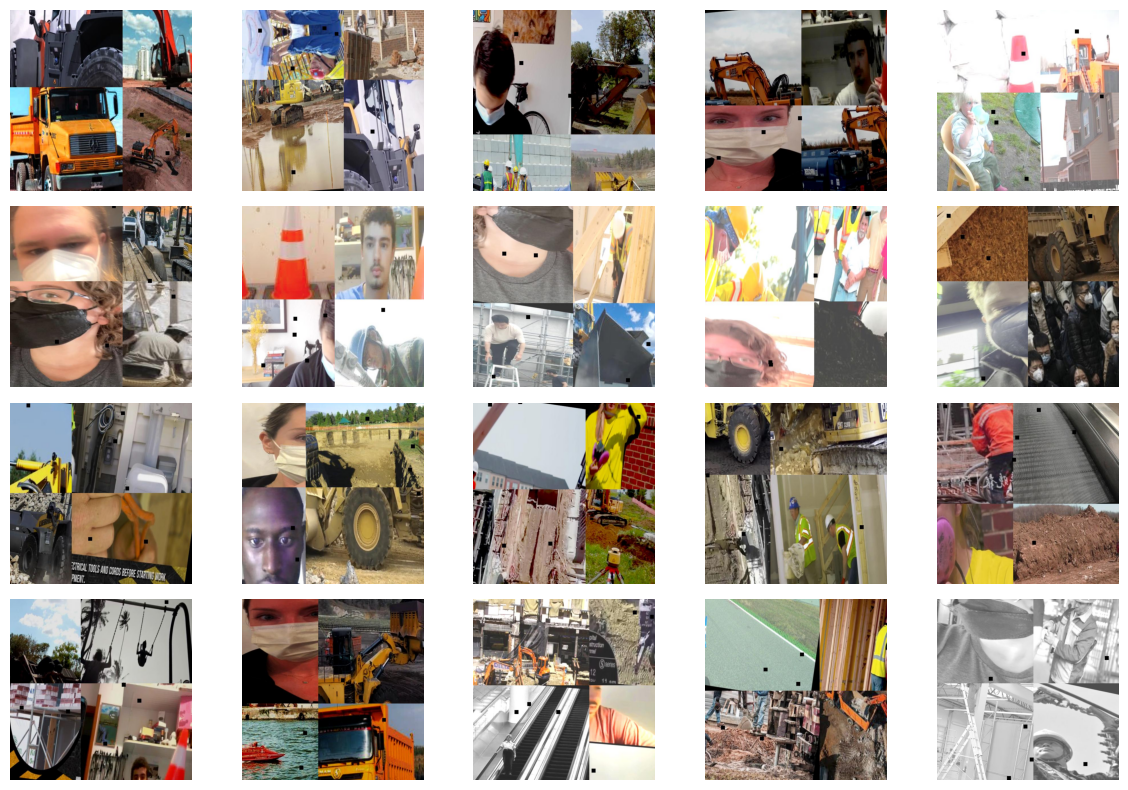

In [12]:
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)
# plot_random_images_from_folder(folder_path, num_images=20, seed=54)

## Image properties

In [13]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [14]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

## Dataset statistics

In [15]:
%%time
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: user 289 ms, sys: 257 ms, total: 545 ms
Wall time: 25.6 s


,Mode,Hardhat,Mask,NO-Hardhat,NO-Mask,NO-Safety Vest,Person,Safety Cone,Safety Vest,machinery,vehicle,Data_Volume
0,train,1314,1096,1380,1531,1864,2526,631,1319,2101,744,2605
1,valid,42,19,37,44,56,84,13,28,26,16,114
2,test,30,16,25,30,36,59,8,22,22,15,82


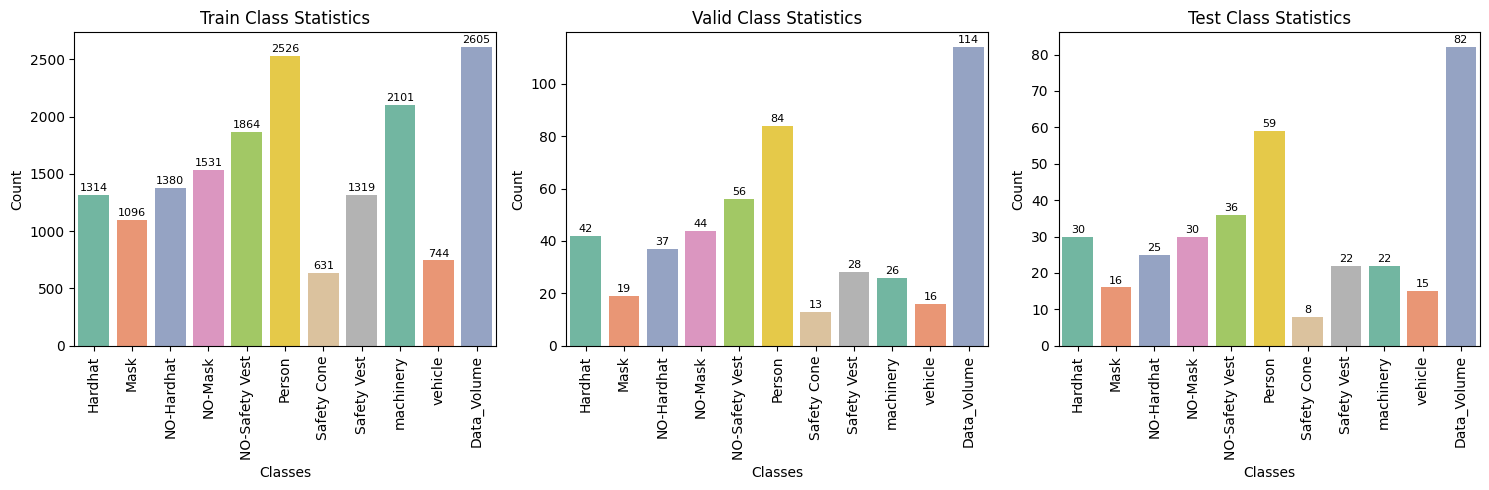

In [16]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

## Image sizes

In [17]:
%%time

for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:')

    img_size = 0
    for file in glob.glob(os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'images', '*')):

        image = Image.open(file)

        if image.size != img_size:
            print(f'{image.size}')
            img_size = image.size
            print('\n')


Image sizes in train set:
(640, 640)



Image sizes in valid set:
(640, 640)



Image sizes in test set:
(640, 640)


CPU times: user 533 ms, sys: 308 ms, total: 841 ms
Wall time: 29.6 s


# Base Model Inference

- Just checking the power of the pretrained model inference on the CSS dataset

In [18]:
CFG.BASE_MODEL_WEIGHTS

'yolov8x.pt'

In [19]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source = example_image_path,

    classes = [0],
    conf = 0.30,
    device = [0,1], # inference with dual GPU
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)

100%|██████████| 131M/131M [00:00<00:00, 234MB/s]

image 1/1 /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg: 640x640 9 persons, 81.3ms
Speed: 7.9ms preprocess, 81.3ms inference, 43.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



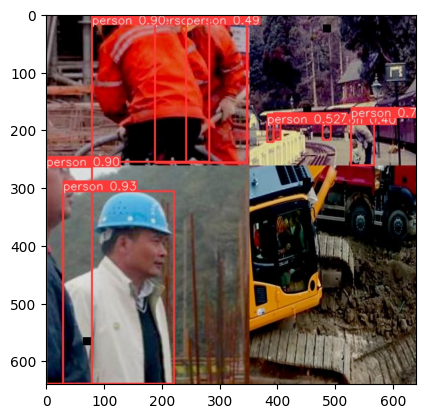

In [20]:
### check predictions with base model
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'/kaggle/working/runs/detect/predict/{example_image_inference_output}')

# Train

[Arguments for training](https://docs.ultralytics.com/modes/train/#arguments)

In [21]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov8x.pt
Epochs:  100
Batch:  16


In [22]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [23]:
%%time

### train
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,
    
    val = True,
    amp = True,    
    exist_ok = True,
    resume = False,
    device = 0,
    verbose = False,
)

Ultralytics YOLOv8.0.173 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=./data.yaml, epochs=100, patience=20, batch=16, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov8x_ppe_css_100_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False

CPU times: user 5h 17min 27s, sys: 27min 39s, total: 5h 45min 7s
Wall time: 6h 3min 54s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7877a031b9d0>
fitness: 0.6896004426131183
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.68017,     0.78454,     0.57355,     0.54288,     0.62454,     0.68231,     0.65114,     0.75161,     0.81858,     0.55391])
names: {0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest', 5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'machinery', 9: 'vehicle'}
plot: True
results_dict: {'metrics/precision(B)': 0.9698227093696108, 'metrics/recall(B)': 0.8203267873384471, 'metrics/mAP50(B)': 0.8990992912108394, 'metrics/mAP50-95(B)': 0.6663227927689269, 'fitness': 0.6896004426131183}
save_dir: PosixPath('runs/detect/yolov8x_ppe_css_100_epochs')
speed: {'preprocess': 1.9949967401

# Export

- [Export mode](https://docs.ultralytics.com/modes/export/) is used for exporting a YOLOv8 model to a format that can be used for deployment. In this mode, the model is converted to a format that can be used by other software applications or hardware devices. This mode is useful when deploying the model to production environments.

In [24]:
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

In [25]:
# Export the model
model.export(
    format = 'openvino', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.0.173 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
Model summary (fused): 268 layers, 68133198 parameters, 0 gradients

PyTorch: starting from 'runs/detect/yolov8x_ppe_css_100_epochs/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (130.4 MB)

ONNX: starting export with onnx 1.14.1 opset 17...


================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



ONNX: export success ✅ 5.0s, saved as 'runs/detect/yolov8x_ppe_css_100_epochs/weights/best.onnx' (260.1 MB)
requirements: Ultralytics requirement ['openvino-dev>=2023.0'] not found, attempting AutoUpdate...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires dask==2023.7.1, but you have dask 2023.8.1 which is incompatible.
fitter 1.6.0 requires pandas<3.0.0,>=2.0.3, but you have pandas 2.0.2 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.10.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 67.6 MB/s eta 0:00:00
  Preparing meta

'runs/detect/yolov8x_ppe_css_100_epochs/weights/best_openvino_model'

# Train results

In [26]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['./runs/detect/yolov8x_ppe_css_100_epochs/confusion_matrix.png',
 './runs/detect/yolov8x_ppe_css_100_epochs/PR_curve.png',
 './runs/detect/yolov8x_ppe_css_100_epochs/results.png',
 './runs/detect/yolov8x_ppe_css_100_epochs/confusion_matrix_normalized.png',
 './runs/detect/yolov8x_ppe_css_100_epochs/P_curve.png',
 './runs/detect/yolov8x_ppe_css_100_epochs/R_curve.png',
 './runs/detect/yolov8x_ppe_css_100_epochs/F1_curve.png',
 './runs/detect/yolov8x_ppe_css_100_epochs/labels_correlogram.jpg',
 './runs/detect/yolov8x_ppe_css_100_epochs/labels.jpg']

./runs/detect/yolov8x_ppe_css_100_epochs/F1_curve.png


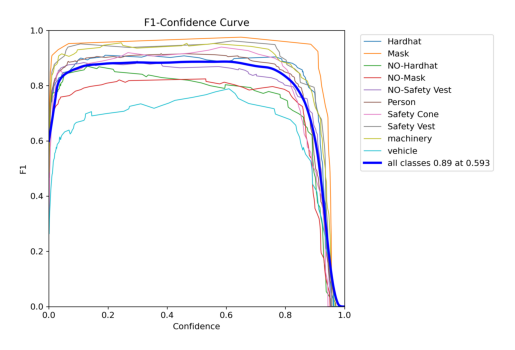



./runs/detect/yolov8x_ppe_css_100_epochs/PR_curve.png


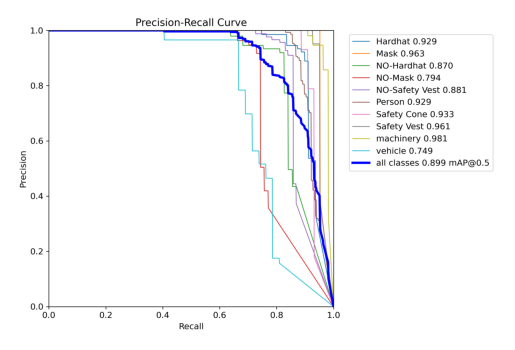



./runs/detect/yolov8x_ppe_css_100_epochs/P_curve.png


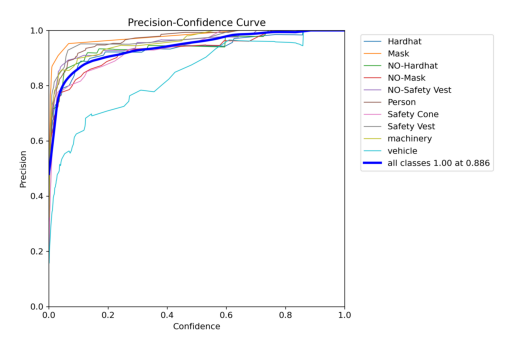



./runs/detect/yolov8x_ppe_css_100_epochs/R_curve.png


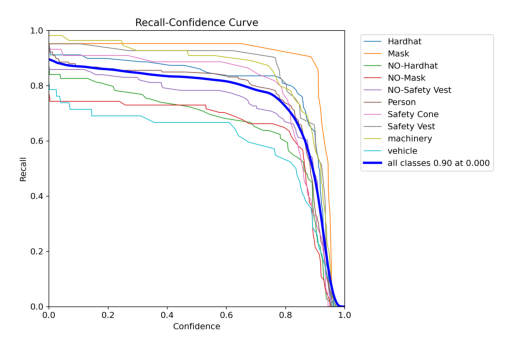



./runs/detect/yolov8x_ppe_css_100_epochs/confusion_matrix.png


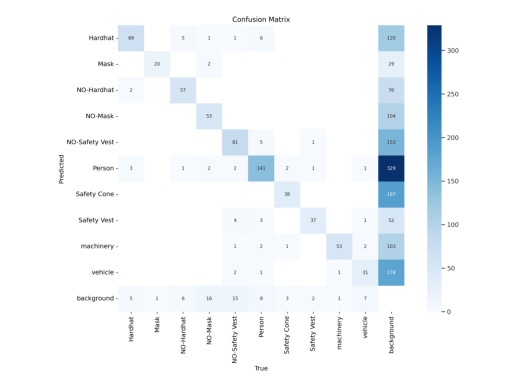



./runs/detect/yolov8x_ppe_css_100_epochs/confusion_matrix_normalized.png


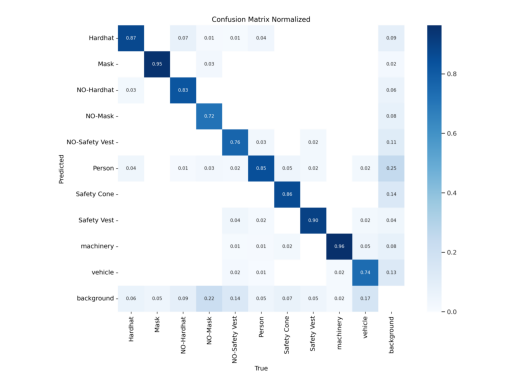



./runs/detect/yolov8x_ppe_css_100_epochs/labels.jpg


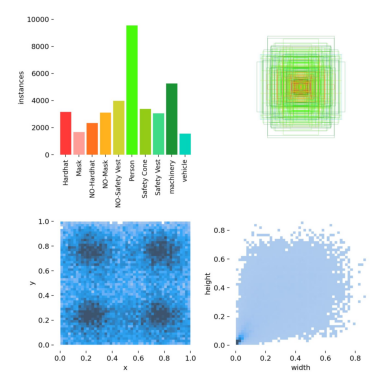



./runs/detect/yolov8x_ppe_css_100_epochs/labels_correlogram.jpg


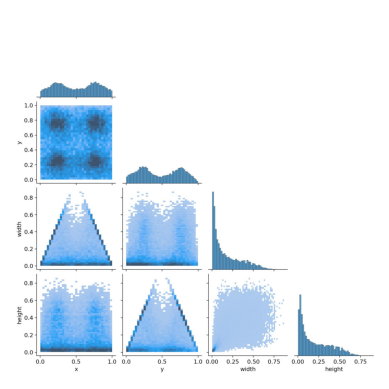



./runs/detect/yolov8x_ppe_css_100_epochs/results.png


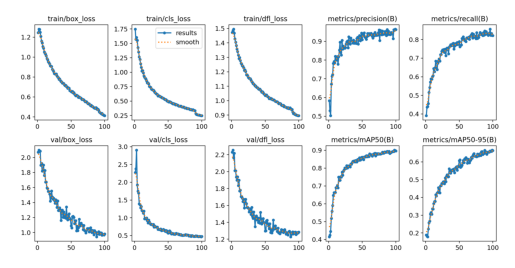

In [27]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

In [28]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.24460,1.74850,1.47180,0.58345,0.39075,0.41533,0.18834,2.07160,2.27570,2.2303,0.000237,0.000237,0.000237
1,2,1.28150,1.57080,1.48670,0.52938,0.43661,0.42392,0.18126,2.09820,2.37630,2.2551,0.000470,0.000470,0.000470
2,3,1.27920,1.60210,1.49610,0.50309,0.44004,0.44553,0.17843,2.08050,2.90390,2.1638,0.000698,0.000698,0.000698
3,4,1.24930,1.55290,1.46840,0.67170,0.45541,0.51848,0.22191,2.08460,1.92080,2.2188,0.000693,0.000693,0.000693
4,5,1.20790,1.42520,1.42810,0.71385,0.51622,0.55764,0.25707,1.89670,1.74780,2.0130,0.000693,0.000693,0.000693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0.43488,0.25953,0.90109,0.91428,0.85656,0.89469,0.66117,0.96468,0.47674,1.2557,0.000050,0.000050,0.000050
96,97,0.42302,0.25481,0.89907,0.96200,0.82246,0.89298,0.66024,0.97186,0.47342,1.2674,0.000042,0.000042,0.000042
97,98,0.42146,0.25274,0.89751,0.95890,0.83273,0.90107,0.65958,0.97576,0.47264,1.2810,0.000035,0.000035,0.000035
98,99,0.41404,0.24918,0.89610,0.96573,0.82216,0.89857,0.66613,0.96875,0.46577,1.2749,0.000028,0.000028,0.000028


In [29]:
print('*'*50)
print('\nBest Training loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('*'*50)
print('\nBest Validation loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')
print('*'*50)

**************************************************

Best Training loss:  0.41219 , on epoch:  100 

**************************************************

Best Validation loss:  0.94347 , on epoch:  88 

**************************************************


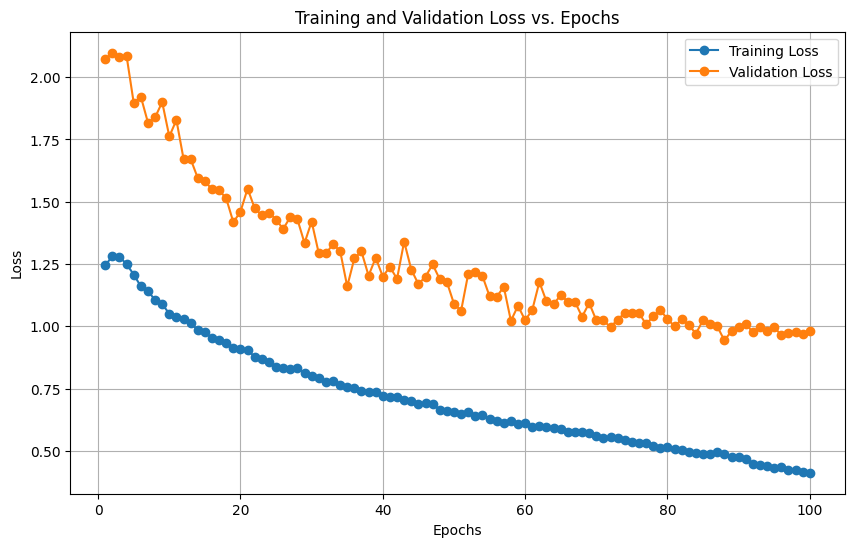

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['train/box_loss'], label='Training Loss', marker='o', linestyle='-')
plt.plot(df['epoch'], df['val/box_loss'], label='Validation Loss', marker='o', linestyle='-')

plt.title('Training and Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()

# Validation results

In [31]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [32]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

./runs/detect/yolov8x_ppe_css_100_epochs/val_batch0_labels.jpg


./runs/detect/yolov8x_ppe_css_100_epochs/val_batch0_pred.jpg


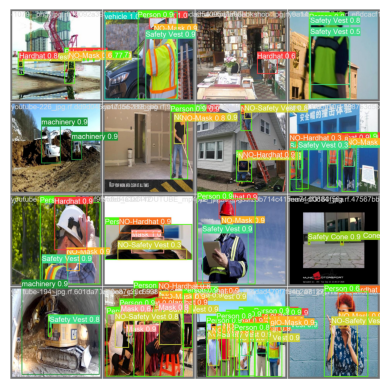

In [33]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)

# Conclusions

- So now the model is trained and we have customized Yolo to detect PPE.
- In my [next notebook](https://www.kaggle.com/hinepo/yolov8-inference-for-red-zone-application) I will use this model to make inference on a video, and combine the PPE detection with a Red Zone application.
- Upvote if you liked it!